In [352]:
import imodels
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd

In [351]:
def plotting(data_list):
    fig, axs = plt.subplots(2, 2,layout='constrained')
    colors = [tuple(np.random.uniform(0,1, size=3)) for i in range(5)]
    for j,key in enumerate(data_list):
        x = data_list[key]["maxnd"]
        for i, col in  enumerate(data_list[key].columns[:-1]):
            axs[int(j/2),j%2].plot(x, data_list[key][col], color = colors[i], label = "Lambda = " + str(col))    
    axs[0,0].legend()
    plt.show()

def simulation(m = 500):
    def lin_func(n,s,p):
        rho = 0.35
        inds = list(range(p))
        Sigma = rho**abs(np.subtract.outer(inds,inds))
        X = np.random.multivariate_normal(np.zeros(p),Sigma,n)
        beta = np.concatenate([np.ones(s),np.zeros(p-s)])
        mu = X @ beta
        return X,mu
    
    def mars_func(n):
        X = np.random.uniform(0,1,5*n)
        X = np.reshape(X,(n,5))
        mu =  0.1*np.exp(4*X[:,0]) + \
        4/(1+np.exp(-20*(X[:,1]-0.5))) + \
        3*X[:,2] + \
        2*X[:,3] + \
        X[:,4]
        return X,mu
    lambdas = [0,0.1,1,10,100]
    v_mars2 = 6.29620
    snr = 3.52
    sigma = (v_mars2/snr)**0.5
    n_lst = [100,500,100,1000]
    p_lst = [10,100,1000,0]
    s_lst = [5,5,10,0]
    data_list = {"lin_small":[],"lin_medium":[],"lin_large":[],"MARSadd":[]}
    for n,p,s,key in zip(n_lst,p_lst,s_lst,list(data_list.keys())):
        if key == "MARSadd":
            X, mu = mars_func(n)

        else:
            X, mu = lin_func(n,s,p)           
        maxnd = np.ceil(np.linspace(2,n/5,num = 9)).astype('int')
        ip = np.zeros((len(maxnd),len(lambdas),m))
        for i in range(m):
            eps = np.random.normal(0, 1, n) * sigma
            y = mu + eps
            for k, nodes in enumerate(maxnd):
                model = RandomForestRegressor(max_leaf_nodes = nodes)  #, max_leaf_nodes=15)
                model.fit(X, y)
                y_pred = model.predict(X)
                ip[k,0,i] = np.sum(y_pred*eps)
                for j,lam in enumerate(lambdas[1:]):
                    mshrunk = imodels.HSTreeRegressor(deepcopy(model), reg_param=lam)
                    y_pred = mshrunk.predict(X)
                    ip[k,j+1,i] = np.sum(y_pred*eps)
        res = np.mean(ip,axis=2)/sigma**2
        data = pd.DataFrame(res,columns = lambdas)
        data["maxnd"] = maxnd
        data_list[key] = data
    return data_list


In [353]:
data_list = simulation(10)

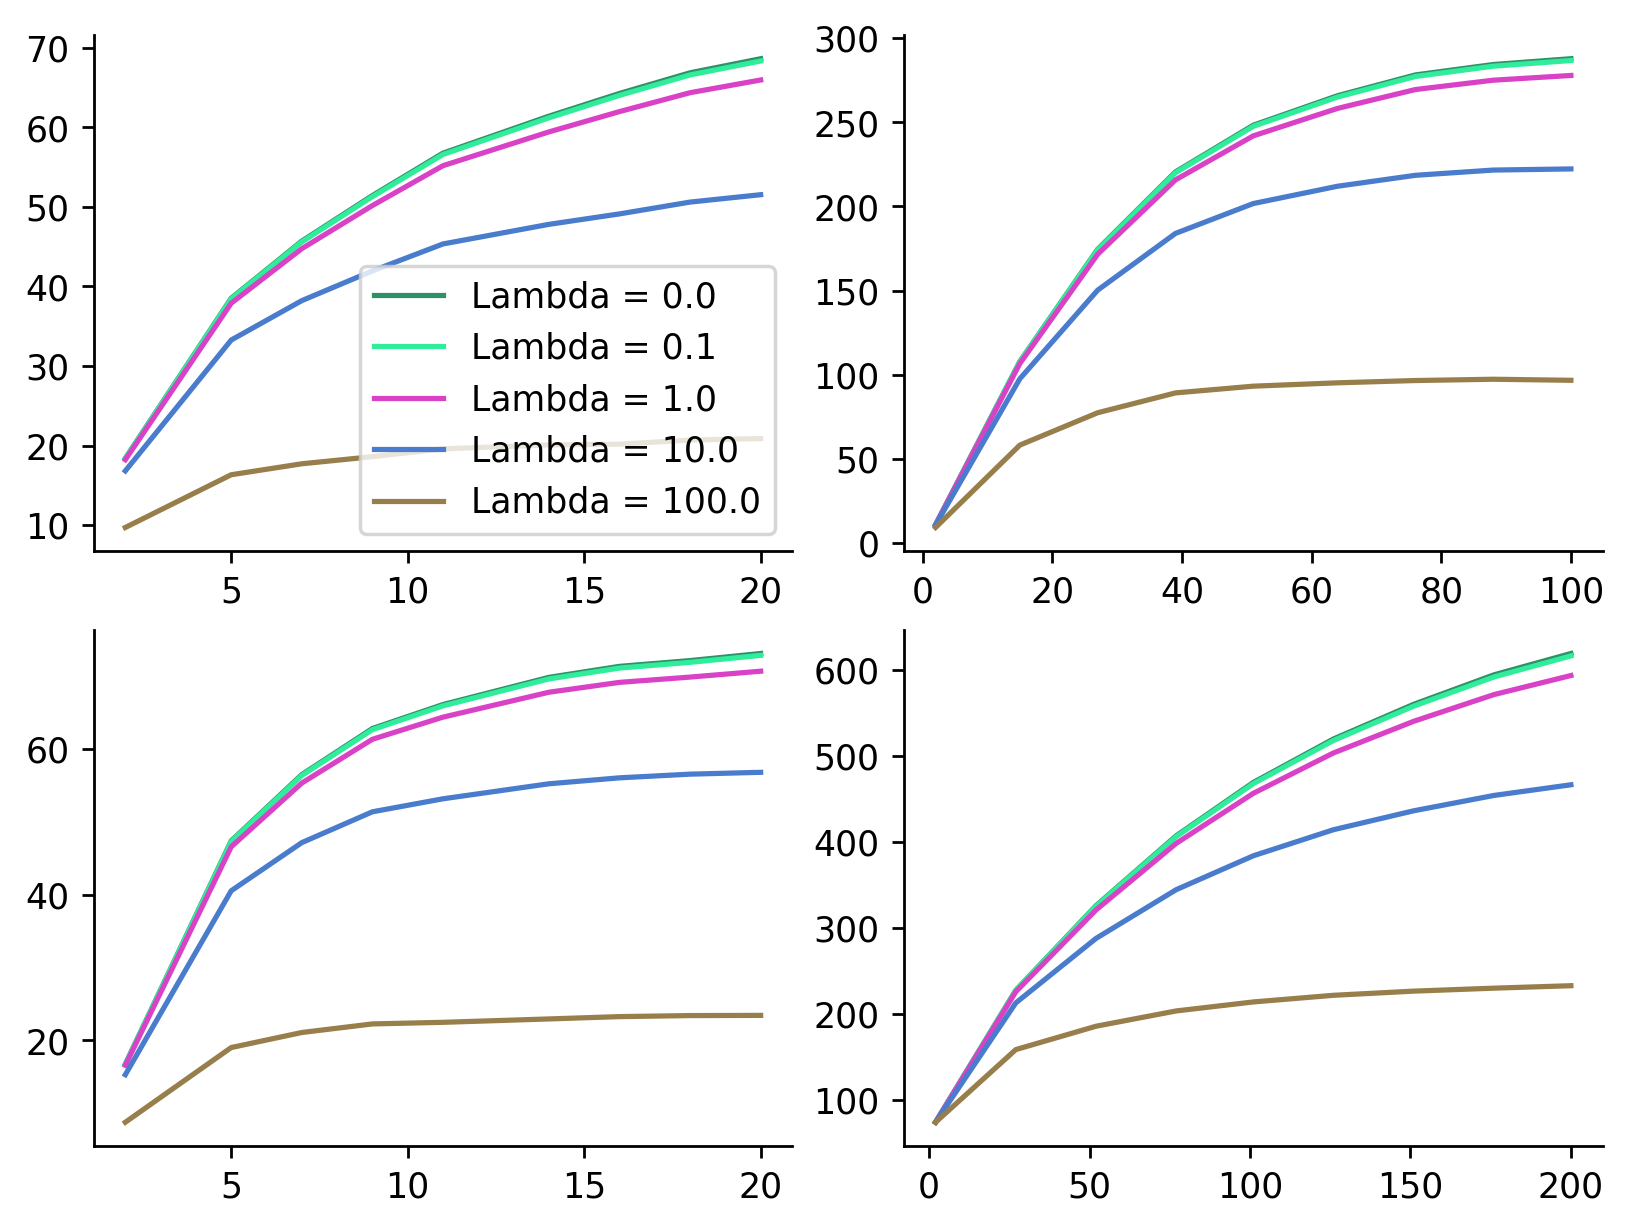

In [354]:
plotting(data_list)